# Lab 6: Airline Tweets with (and without) Embeddings

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/DSML4220/blob/main/lab6_airline_tweets_w_embeddings.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/sgeinitz/DSML4220/blob/main/lab6_airline_tweets_w_embeddings.ipynb)

In this notebook we'll build revisit the Airline Tweets dataset (from [Lab 1](https://github.com/sgeinitz/DSML4220/blob/main/lab1_text_data.ipynb)) and compare using an MLP with one-hot encodings as the input vs using word embeddings as the input.

In this lab there are three (3) questions/tasks. These questions are listed here but are also inline below.

1. Q1: Choose two words to compare (different from "_wonderful_" vs "_incredible_"). Re-run the parts of the notebook that plot the histogram of the differences between learned weight parameter values for each of your chosen words across the 128 hidden units in the first layer.


2. Q2: Add your two words the list of words whose embeddings are displayed and compared. Do your two chosen words have similar embeddings? In other words, is the distance between your embeddings very small?




3. Q3: Compare the size of the two models used in this notebook, one of which uses one-hot encoded inputs and the other which uses GloVe embeddings.




In [52]:
pip install numpy==1.24.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.2 requires torch==2.0.1, but you have torch 2.1.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.1 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.1 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.1 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.24.1 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.1 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but yo

In [25]:
!pip install torchtext==0.16.0

In [26]:
!pip install torchmetrics

In [6]:
import torch
import random
import tqdm #import notebook
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import pairwise_cosine_similarity


In [7]:
data_URL = 'https://raw.githubusercontent.com/sgeinitz/DSML4220/main/data/airlinetweets.csv'
df = pd.read_csv(data_URL)
print(f"df.shape: {df.shape}")
pd.set_option("display.max_colwidth", 240)
df.head(10)

df.shape: (10000, 2)


,sentiment,text
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!
4,negative,@VirginAmerica hold times at call center are a bit much
5,negative,@USAirways not moving we are in the tarmac delayed for some unknown reason. I'll keep you posted
6,neutral,"@JetBlue What about if I booked it through Orbitz? My email is correct, but there's a middle party."
7,negative,@united 2nd flight also delayed no pilots! But they boarded is so we can just sit here! #scheduling
8,negative,".@AmericanAir after 50 minutes on hold, and another 30 minutes on the call yes. Going to be pushing it to get to the airport on time now"
9,positive,@JetBlue flight 117. proud to fly Jet Blue!


In [8]:
random.seed(2)
indices = list(range(len(df)))
random.shuffle(indices)

df_test = df.iloc[indices[9000:],]
df = df.iloc[indices[:9000],]

In [9]:
df_test.shape
df.shape

(9000, 2)

Recall that about 2/3 of the data have negative labels, and that the remaining labels are roughly split between positive and neutral (slightly more neutral than positive).

In [10]:
df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
negative,0.653556
neutral,0.191111
positive,0.155333


Let's start with the nltk TweetTokenizer, which will split the text into separate words and characters based on common Twitter conventions.

In [11]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer()
df['tokens_raw'] = df['text'].apply(lambda x: tk.tokenize(x.lower()))
df.head()

,sentiment,text,tokens_raw
7010,positive,@AmericanAir I ended up on a flight to LA my fourth time on standby. Thanks! http://t.co/NA5G5EAKPA,"[@americanair, i, ended, up, on, a, flight, to, la, my, fourth, time, on, standby, ., thanks, !, http://t.co/na5g5eakpa]"
9477,neutral,@JetBlue thanks! I only loose 'em at airports...1st time we found it. I think @fitbit needs to make flexes that stay on when carrying bags!,"[@jetblue, thanks, !, i, only, loose, ', em, at, airports, ..., 1st, time, we, found, it, ., i, think, @fitbit, needs, to, make, flexes, that, stay, on, when, carrying, bags, !]"
4584,neutral,@SouthwestAir can take u to Midway-Chicago March 8th-April 6th. Can't make it then? @AmericanAir can get u to @fly2ohare year round. #FlyPBI,"[@southwestair, can, take, u, to, midway-chicago, march, 8th, -, april, 6th, ., can't, make, it, then, ?, @americanair, can, get, u, to, @fly2ohare, year, round, ., #flypbi]"
3460,negative,@AmericanAir is this how you let your employees treat your loyal customers? #attackingbabymomma #crazinessintherockies,"[@americanair, is, this, how, you, let, your, employees, treat, your, loyal, customers, ?, #attackingbabymomma, #crazinessintherockies]"
9065,negative,@USAirways so I still need to stay on hold? http://t.co/04SDytT7zd,"[@usairways, so, i, still, need, to, stay, on, hold, ?, http://t.co/04sdytt7zd]"


Previously, we did not do a lot of exploratory data analysis (EDA) on this airline tweet dataset. We will not do too much here either, but at the very least let's look at a histogram of the lengths of the tweets. Note that here we are defining length to be the number of tokens, but it may also be useful to look at the number of characters. And, of course, there are other EDA steps we could do.

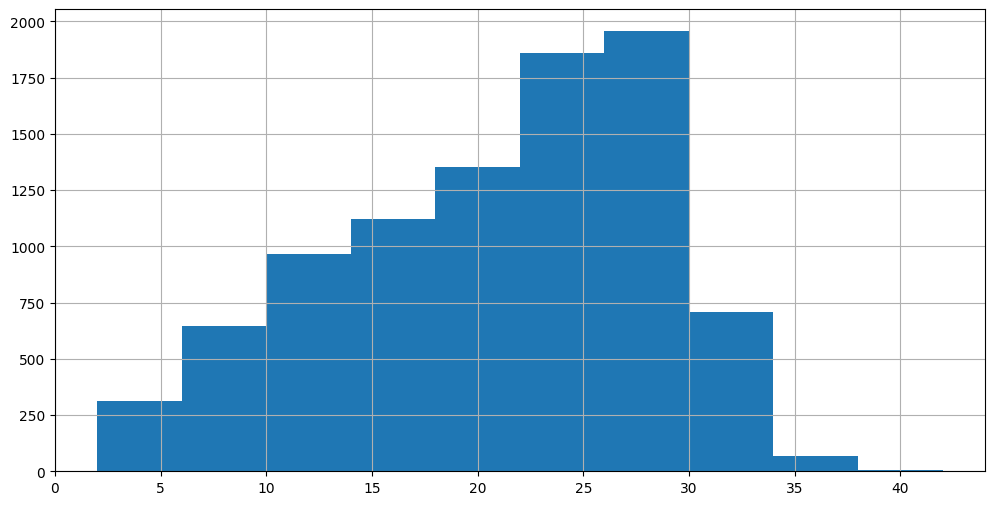

In [12]:
df['tweet_length'] = df['tokens_raw'].apply(lambda x: len(x))
plt.figure(figsize=(12,6))
df['tweet_length'].hist() #bins=100, range=(0,45), width=0.9) #, df['tweet_length'].mean(), df['tweet_length'].median()
plt.show()

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Next, let's remove common stop words (e.g. "_the_", "_in_", etc.). In this next cell we will also remove some characters/punctuation, as well as hashtag tokens.

Note: If the following cell causes an error, then uncomment the code cell above and run it to download and load the nltk stopwords.

In [14]:
import re
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
chars2remove = set(['.','!','/', '?'])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in stops])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^#', w)]) # remove hashtags
#df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^http', w)]) # remove web links
#df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^@', w)]) # remove web links

df.head()

,sentiment,text,tokens_raw,tweet_length
7010,positive,@AmericanAir I ended up on a flight to LA my fourth time on standby. Thanks! http://t.co/NA5G5EAKPA,"[@americanair, ended, flight, la, fourth, time, standby, thanks, http://t.co/na5g5eakpa]",18
9477,neutral,@JetBlue thanks! I only loose 'em at airports...1st time we found it. I think @fitbit needs to make flexes that stay on when carrying bags!,"[@jetblue, thanks, loose, ', em, airports, ..., 1st, time, found, think, @fitbit, needs, make, flexes, stay, carrying, bags]",31
4584,neutral,@SouthwestAir can take u to Midway-Chicago March 8th-April 6th. Can't make it then? @AmericanAir can get u to @fly2ohare year round. #FlyPBI,"[@southwestair, take, u, midway-chicago, march, 8th, -, april, 6th, can't, make, @americanair, get, u, @fly2ohare, year, round]",27
3460,negative,@AmericanAir is this how you let your employees treat your loyal customers? #attackingbabymomma #crazinessintherockies,"[@americanair, let, employees, treat, loyal, customers]",15
9065,negative,@USAirways so I still need to stay on hold? http://t.co/04SDytT7zd,"[@usairways, still, need, stay, hold, http://t.co/04sdytt7zd]",11


For the final step of text pre-processing we will lemmatize the tokens. Note that there are much better ways to do this but that we want to use a simple lemmatizer. For example, some lemmatizers also utilize a model internally to predict the part-of-speech for each word, since whether the word is a noun, adjective, verb, etc. will affect how lemmatization is done. Since we want to keep things simple here, and focus only on the lemmatization step, we'll assume every word is the same part of speech. Note that this is not by any means ideal (try to identify the incorrectly lemmatized token in the five tweets printed out below). In practice we would certainly utilize a 'smarter' lemmatizer.

The last step below is to combined the tokens back into a single string, which is stored in the column `textclean`.

In [15]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
#df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

df['textclean'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,sentiment,text,tokens_raw,tweet_length,tokens,textclean
7010,positive,@AmericanAir I ended up on a flight to LA my fourth time on standby. Thanks! http://t.co/NA5G5EAKPA,"[@americanair, ended, flight, la, fourth, time, standby, thanks, http://t.co/na5g5eakpa]",18,"[@americanair, end, flight, la, fourth, time, standby, thank, http://t.co/na5g5eakpa]",@americanair end flight la fourth time standby thank http://t.co/na5g5eakpa
9477,neutral,@JetBlue thanks! I only loose 'em at airports...1st time we found it. I think @fitbit needs to make flexes that stay on when carrying bags!,"[@jetblue, thanks, loose, ', em, airports, ..., 1st, time, found, think, @fitbit, needs, make, flexes, stay, carrying, bags]",31,"[@jetblue, thank, loose, ', em, airports, ..., 1st, time, find, think, @fitbit, need, make, flex, stay, carry, bag]",@jetblue thank loose ' em airports ... 1st time find think @fitbit need make flex stay carry bag
4584,neutral,@SouthwestAir can take u to Midway-Chicago March 8th-April 6th. Can't make it then? @AmericanAir can get u to @fly2ohare year round. #FlyPBI,"[@southwestair, take, u, midway-chicago, march, 8th, -, april, 6th, can't, make, @americanair, get, u, @fly2ohare, year, round]",27,"[@southwestair, take, u, midway-chicago, march, 8th, -, april, 6th, can't, make, @americanair, get, u, @fly2ohare, year, round]",@southwestair take u midway-chicago march 8th - april 6th can't make @americanair get u @fly2ohare year round
3460,negative,@AmericanAir is this how you let your employees treat your loyal customers? #attackingbabymomma #crazinessintherockies,"[@americanair, let, employees, treat, loyal, customers]",15,"[@americanair, let, employees, treat, loyal, customers]",@americanair let employees treat loyal customers
9065,negative,@USAirways so I still need to stay on hold? http://t.co/04SDytT7zd,"[@usairways, still, need, stay, hold, http://t.co/04sdytt7zd]",11,"[@usairways, still, need, stay, hold, http://t.co/04sdytt7zd]",@usairways still need stay hold http://t.co/04sdytt7zd


Now we will perform one-hot encoding using sklearn's, `CountVectorizer`, with the option `binary=True`. We'll go ahead and call the resulting vectorized data, `X`, or `X_train` since it is only the training dataset. As with conventional statistical models, "_X_" represents the set of predictors, or independent variables.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

#count_vectorizer = CountVectorizer(binary=True)
count_vectorizer = CountVectorizer(binary=True, min_df=2)
X_np = count_vectorizer.fit_transform(df['textclean']).toarray()

print(f"X_np.shape = {X_np.shape}")
type(X_np)

X_np.shape = (9000, 3842)


numpy.ndarray

Here is the full vocabulary created by the the `CountVectorizer`.

In [17]:
vocab = count_vectorizer.vocabulary_
vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: item[1], reverse=False)}
print(vocab)

{'00': 0, '000': 1, '01': 2, '02': 3, '03': 4, '05': 5, '05am': 6, '08': 7, '0hp': 8, '10': 9, '100': 10, '1000': 11, '101': 12, '1027': 13, '103': 14, '104': 15, '1081': 16, '10am': 17, '10hrs': 18, '10mins': 19, '10pm': 20, '10th': 21, '11': 22, '1109': 23, '1137': 24, '1142': 25, '117': 26, '1170': 27, '118': 28, '11am': 29, '11pm': 30, '11th': 31, '12': 32, '120': 33, '1200': 34, '1220': 35, '123': 36, '1230': 37, '1254': 38, '12pm': 39, '13': 40, '130': 41, '136': 42, '1389': 43, '13th': 44, '14': 45, '140': 46, '145': 47, '1472': 48, '15': 49, '150': 50, '152': 51, '1533': 52, '1534': 53, '1562': 54, '1571aus': 55, '15minutes': 56, '15th': 57, '16': 58, '1600': 59, '1613': 60, '1625': 61, '165': 62, '1657': 63, '17': 64, '1700': 65, '1701': 66, '174': 67, '18': 68, '180': 69, '1800': 70, '1826': 71, '1861': 72, '1898': 73, '19': 74, '1917': 75, '1970': 76, '1997': 77, '1am': 78, '1hr': 79, '1k': 80, '1m': 81, '1pm': 82, '1st': 83, '1ywxrfn0gr': 84, '20': 85, '200': 86, '2000': 87

---

### Q1: Choose two words to compare (different from "_wonderful_" vs "_incredible_").

Below you will choose your two words, which have similar meaning and which you suspect the model will treat similarly. Then, re-train the model and plot the histogram of the differences between learned weight values for each of your chosen words across the 128 hidden units in the first layer. Did the histograms show that the learned weight values were similar for your words? More similar than for the neighboring words compared to each other?

`I compared the words "happy" and "awesome". The histogram of weight differences across 128 hidden units shows most values are below 0.1, similar to the distribution for "wonderful" vs "incredible". This might be due the model learning similar representations for "happy" and "awesome", which shows their similarity.`

---

In [89]:
word1 = 'happy'
word2 = 'awesome'

word1_idx = vocab[word1]
print(f"The index for '{word1}': {word1_idx}")

word2_idx = vocab[word2]
print(f"The index for '{word2}': {word2_idx}")


The index for 'happy': 1756
The index for 'awesome': 567


Next, let's look at the tweets themselves that contained the word _"great"_.

In [90]:
rows_w_word1 = np.where(X_np[:, word1_idx] == 1)[0]
print(rows_w_word1)
df.iloc[rows_w_word1,]

[  17  191  224  394  528  881 1038 1215 1273 1531 1985 2489 2536 2547
 2553 3116 3155 3559 3827 3886 3996 4011 4136 4175 4361 5253 5433 5500
 5601 5642 5722 5909 6007 6030 6123 6190 6494 6514 6606 6618 6781 6895
 6988 7294 7305 7488 7790 7810 7826 7853 8366 8466 8686 8783 8901]


,sentiment,text,tokens_raw,tweet_length
1298,negative,@AmericanAir Still waiting on bags from flight 1613/2440 yesterday First Class passenger not happy with your service.,"[@americanair, still, waiting, on, bags, from, flight, 1613/2440, yesterday, first, class, passenger, not, happy, with, your, service, .]",18
4384,negative,@SouthwestAir not to mention I now have to sit in the airport for 4 hours. You've ruined my trip. I am not happy and want compensation.,"[@southwestair, not, to, mention, i, now, have, to, sit, in, the, airport, for, 4, hours, ., you, ', ve, ruined, my, trip, ., i, am, not, happy, and, want, compensation, .]",31
247,negative,"@JetBlue She claimed that she did, but I was not happy with the way I was treated.","[@jetblue, she, claimed, that, she, did, ,, but, i, was, not, happy, with, the, way, i, was, treated, .]",19
9794,neutral,@USAirways @VincesViews there are significant number of folks on 686 connecting to 599 a few minutes hold would make many happy,"[@usairways, @vincesviews, there, are, significant, number, of, folks, on, 686, connecting, to, 599, a, few, minutes, hold, would, make, many, happy]",21
954,positive,@JetBlue so happy you can accommodate peanut/treenut allergies on flight! 1st online cover from air provider,"[@jetblue, so, happy, you, can, accommodate, peanut/treenut, allergies, on, flight, !, 1st, online, cover, from, air, provider]",17
2067,negative,@AmericanAir AA 1657 was also over an hour Late Flight to depart Ohare and now we have no luggage. Not happy standing in a long line at baggage svc,"[@americanair, aa, 1657, was, also, over, an, hour, late, flight, to, depart, ohare, and, now, we, have, no, luggage, ., not, happy, standing, in, a, long, line, at, baggage, svc]",30
9707,positive,@VirginAmerica happy to spend the day together. Let's do this!,"[@virginamerica, happy, to, spend, the, day, together, ., let, ', s, do, this, !]",14
7047,negative,@SouthwestAir took our BOS to BWI plane for a flight to StL and promised a replacement 1.5 hours Late Flightr. Now 2.5 hours delayed. Not happy.,"[@southwestair, took, our, bos, to, bwi, plane, for, a, flight, to, stl, and, promised, a, replacement, 1, ., 5, hours, late, flightr, ., now, 2, ., 5, hours, delayed, ., not, happy, .]",33
1762,negative,@AmericanAir you delayed me for 15 hours in Chicago and still managed to lose my bag! Really not happy,"[@americanair, you, delayed, me, for, 15, hours, in, chicago, and, still, managed, to, lose, my, bag, !, really, not, happy]",20
4669,neutral,@SouthwestAir get me on flight 4146 to denver and I'll be more than happy !!!!!,"[@southwestair, get, me, on, flight, 4146, to, denver, and, i, ', ll, be, more, than, happy, !, !, !, !, !]",21


In [91]:
rows_w_word2 = np.where(X_np[:, word2_idx] == 1)[0]
print(rows_w_word2)
df.iloc[rows_w_word2,]

[ 307  374  751  780  826  846  999 1012 1053 1253 1333 1452 1618 1755
 1775 1799 1917 1926 2026 2071 2404 2805 2909 3002 3083 3137 3341 3363
 3489 3748 4078 4265 4396 4442 4604 4616 4791 4904 4958 4980 5015 5211
 5268 5420 5428 5471 5662 5711 5715 5755 5887 6033 6185 6217 6332 6392
 6433 6690 6739 7022 7456 7812 7840 7938 7952 7960 8354 8429 8596 8621
 8634 8646 8673 8930]


,sentiment,text,tokens_raw,tweet_length
3159,positive,@SouthwestAir you should know the crew today on flight #1071 AUS to PDX was awesome! #SWA,"[@southwestair, you, should, know, the, crew, today, on, flight, #1071, aus, to, pdx, was, awesome, !, #swa]",17
4893,negative,"@AmericanAir When I left Orlando, I was 2nd in line for standby. I land and I'm 4th. 'Priority members get first available seats'. Awesome.","[@americanair, when, i, left, orlando, ,, i, was, 2nd, in, line, for, standby, ., i, land, and, i, ', m, 4th, ., ', priority, members, get, first, available, seats, ', ., awesome, .]",33
368,positive,"@JetBlue Another awesome telephone experience with @JetBlue Thank you, Cory! #Greatcustomerservice✈☺","[@jetblue, another, awesome, telephone, experience, with, @jetblue, thank, you, ,, cory, !, #greatcustomerservice✈☺]",13
548,positive,@JetBlue in the sky on flight 833 from BOS to SFO. Awesome crew! Helene rocks!,"[@jetblue, in, the, sky, on, flight, 833, from, bos, to, sfo, ., awesome, crew, !, helene, rocks, !]",18
7073,positive,@JetBlue Amazingly Awesome customer service from your reservation agents tonight. Helping correct a mistake. I so love this airline. :),"[@jetblue, amazingly, awesome, customer, service, from, your, reservation, agents, tonight, ., helping, correct, a, mistake, ., i, so, love, this, airline, ., )]",23
...,...,...,...,...
9793,positive,@SouthwestAir crew on flight 206 is awesome! Tell them I sent this tweet and maybe they will give me free wifi... #canthurtasking,"[@southwestair, crew, on, flight, 206, is, awesome, !, tell, them, i, sent, this, tweet, and, maybe, they, will, give, me, free, wifi, ., ., ., #canthurtasking]",26
8961,positive,@united awesome I'll book my next Christmas vacatinn this December any other ways you want to devalue mileage plus.,"[@united, awesome, i, ', ll, book, my, next, christmas, vacatinn, this, december, any, other, ways, you, want, to, devalue, mileage, plus, .]",22
1211,positive,"@VirginAmerica Thanks so much for the awesome support, you guys rock!","[@virginamerica, thanks, so, much, for, the, awesome, support, ,, you, guys, rock, !]",13
3194,positive,@southwestair your attendants at the ATL airport are awesome! Very helpful with all the Cancelled Flightlations this morning.,"[@southwestair, your, attendants, at, the, atl, airport, are, awesome, !, very, helpful, with, all, the, cancelled, flightlations, this, morning, .]",20


Confirm that the input, `X`, has n rows and a column for each word (token) in the vocabulary.

In [92]:
X = torch.tensor(X_np, dtype=torch.float32)

X.size()

torch.Size([9000, 3842])

In [93]:
# look at one observation and see how may tokens there are (i.e. how many 1's are in the row, and how many 0's)
pd.DataFrame(X_np[1,:]).value_counts()

,count
0,
0,3827
1,15


In [94]:
labels = df['sentiment'].unique()
enum_labels = enumerate(labels)
label_to_idx = dict((lab, i) for i,lab in enum_labels)
print(f"label dictionary: {label_to_idx}")
y = torch.tensor([label_to_idx[lab] for lab in df['sentiment']])

label dictionary: {'positive': 0, 'neutral': 1, 'negative': 2}


In [95]:
class AirlineTweetDataset(Dataset):
    def __init__(self, observations, labels):
        self.obs = observations
        self.labs = labels
        self.create_split(len(observations))

    def create_split(self, n, seed=2, train_perc=0.7):
        random.seed(seed)
        indices = list(range(n))
        random.shuffle(indices)
        self._train_ids = list(indices[:int(n * train_perc)])
        self._test_ids = list(indices[int(n * train_perc):])
        self._split_X = self.obs[self._train_ids]
        self._split_y = self.labs[self._train_ids]

    def set_split(self, split='train'):
        if split == 'train':
            self._split_X = self.obs[self._train_ids]
            self._split_y = self.labs[self._train_ids]
        else:
            self._split_X = self.obs[self._test_ids]
            self._split_y = self.labs[self._test_ids]

    def __len__(self):
        return len(self._split_y)

    def __getitem__(self, idx):
        return {'x':self._split_X[idx], 'y':self._split_y[idx]}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

dataset = AirlineTweetDataset(X, y)
dataset.create_split(len(X), seed=42, train_perc=0.85)

In [96]:
dataset.set_split('train')
print(f"len(dataset) = {len(dataset)}")
#len(dataset[:]['x'])
dataset[0]['x']

len(dataset) = 7650


tensor([0., 0., 0.,  ..., 0., 0., 0.])

Confirm that there are no NaN, and that all numerical values are finite.

In [97]:
dataset[:]['x'].numpy()[0,:5]

array([0., 0., 0., 0., 0.], dtype=float32)

In [98]:
assert not np.any(np.isnan(dataset[:]['x'].numpy()))
assert np.all(np.isfinite(dataset[:]['x'].numpy()))

In [99]:
class AirlineTweetClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input embeddings
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(AirlineTweetClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))

        intermediate_vector = F.relu(self.fc2(intermediate_vector))
        intermediate_vector = self.dropout(intermediate_vector)

        prediction_vector = self.fc3(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

#### Hyperparameters for model with one-hot encoded inputs

In [100]:
batch_size = 32
learning_rate = 0.001
num_epochs = 20
device = 'cpu'

Take one quick look at the size of the training and validation splits.

In [101]:
from torch.utils.data import DataLoader

# For training split
dataset.set_split('train')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(len(dataloader) * batch_size)

# For validation split
dataset.set_split('val')
dataloader = DataLoader(dataset, batch_size=batch_size)
print(len(dataloader) * batch_size)


7680
1376


In [102]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# create the dataset, model and define loss function and optimizer
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
model = AirlineTweetClassifier(len(dataset[0]['x']), 128, 3)
loss_fun = nn.CrossEntropyLoss()#weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [103]:
epoch_bar = tqdm.notebook.tqdm(desc='training routine', total=num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train', total=dataset.get_num_batches(batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val', total=dataset.get_num_batches(batch_size), position=1, leave=True)

losses = {'train':[], 'val':[]}

for epoch in range(num_epochs):

    dataset.set_split('train')
    model.train()
    running_loss_train = 0.0

    for batch_i, batch_data in enumerate(dataloader):
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)

        # forward
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['train'].append(loss.item())
        running_loss_train += loss.item()

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if (batch_i+1) % 10 == 0:
        #    print(f"    train batch {batch_i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
            # update bar
        train_bar.set_postfix(loss=running_loss_train, epoch=epoch)
        train_bar.update()

    train_bar.set_postfix(loss=running_loss_train/dataset.get_num_batches(batch_size), epoch=epoch)
    train_bar.update()


    running_loss_train = running_loss_train / len(dataset)

    dataset.set_split('val')
    model.eval() # turn off the automatic differentiation
    running_loss_val = 0.0

    for batch_i, batch_data in enumerate(dataloader):
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)


        # forward (no backward step for validation data)
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['val'].append(loss.item())
        running_loss_val += loss.item()
        #if (batch_i+1) % 20 == 0:
        #    print(f"    valid batch {i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
        val_bar.set_postfix(loss=running_loss_val, epoch=epoch)
        val_bar.update()

    val_bar.set_postfix(loss=running_loss_val/dataset.get_num_batches(batch_size), epoch=epoch)
    val_bar.update()

    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

    running_loss_val = running_loss_val / len(dataset)


training routine:   0%|          | 0/20 [00:00<?, ?it/s]

split=train:   0%|          | 0/239 [00:00<?, ?it/s]

split=val:   0%|          | 0/42 [00:00<?, ?it/s]

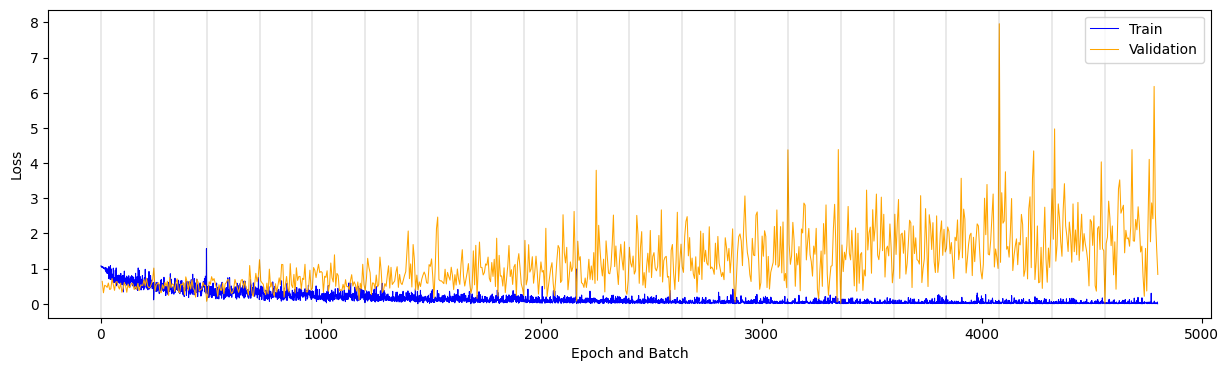

In [104]:
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(num_epochs):
    plt.axvline(x=i*len(losses['train'])/num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [105]:
# Test the model on full validation set
dataset.set_split('val')

y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in dataloader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(dataloader)*batch_size} validation tweets): {100 * correct / total:.2f}%")


Accuracy (on 1376 validation tweets): 78.15%


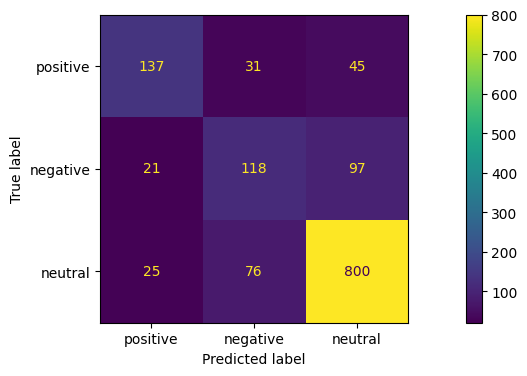

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative','neutral'])
disp.plot()

In [107]:
import torchinfo
torchinfo.summary(model, tuple(dataset[0]['x'].size()))

Layer (type:depth-idx)                   Output Shape              Param #
AirlineTweetClassifier                   [3]                       --
├─Linear: 1-1                            [128]                     491,904
├─Linear: 1-2                            [32]                      4,128
├─Dropout: 1-3                           [32]                      --
├─Linear: 1-4                            [3]                       99
Total params: 496,131
Trainable params: 496,131
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 63.10
Input size (MB): 0.02
Forward/backward pass size (MB): 0.00
Params size (MB): 1.98
Estimated Total Size (MB): 2.00

Let's now retrieve the weight parameters that are associated with the words (i.e. tokens) that have similar meaning, "great", "amazing", "incredible". These words were in the vocabulary at following locations.
* index for 'great': 4140
* index for 'incredible': 4608
* index for 'terrific': 7896

In [108]:
fc1_weights = model.fc1.weight.data
print(f"first model layer has weight matrix with shape = {fc1_weights.shape}")

first model layer has weight matrix with shape = torch.Size([128, 3842])


In [109]:
#wonderful_idx = vocab['wonderful']
#incredible_idx = vocab['incredible']
unit_i = 0
print(f"word1 index: {word1_idx}")
print(f"  fc1_weights[{unit_i},{[word1_idx-1,word1_idx, word1_idx+1]}]: {fc1_weights[unit_i,word1_idx-1:word1_idx+2]}")
print(f"word2 index: {word2_idx}")
print(f"  fc1_weights[{unit_i},{[word2_idx-1,word2_idx, word2_idx+1]}]: {fc1_weights[unit_i,word2_idx-1:word2_idx+2]}")

word1 index: 1756
  fc1_weights[0,[1755, 1756, 1757]]: tensor([ 0.0352, -0.0389,  0.0214])
word2 index: 567
  fc1_weights[0,[566, 567, 568]]: tensor([-0.0493,  0.0026,  0.0413])


In [110]:
diffs = {"cont1":[], "word1_vs_word2":[], "cont2":[]}
for i in range(128):
    diffs["cont1"].append(abs(fc1_weights[i,word1_idx-1] - fc1_weights[i,word2_idx-1]))
    diffs["word1_vs_word2"].append(abs(fc1_weights[i,word1_idx] - fc1_weights[i,word2_idx]))
    diffs["cont2"].append(abs(fc1_weights[i,word1_idx+1] - fc1_weights[i,word2_idx+1]))

# convert each list to a numpy array
for key in diffs:
    diffs[key] = np.array(diffs[key])

In [111]:
# generate summary statistics for the differences for weight values
diffs_df = pd.DataFrame(diffs)
diffs_df.describe()

,cont1,word1_vs_word2,cont2
count,128.000000,128.000000,128.000000
mean,0.050725,0.071959,0.054141
std,0.033431,0.054790,0.048348
min,0.002895,0.000880,0.001943
25%,0.023702,0.036997,0.018813
50%,0.048546,0.056564,0.036790
75%,0.071856,0.101340,0.070204
max,0.163499,0.296239,0.203944


In [112]:
vocab = count_vectorizer.vocabulary_

# find which key vocab is associated with the index 4139
for key, value in vocab.items():
    if value == word1_idx-1:
        w_at_incredible_idx_minus_1 = key
        print(f"word at index {word1_idx-1}: {key}")
    if value == word2_idx-1:
        w_at_wonderful_idx_minus_1 = key
        print(f"word at index {word2_idx-1}: {key}")
    if value == word1_idx+1:
        w_at_incredible_idx_plus_1 = key
        print(f"word at index {word1_idx+1}: {key}")
    if value == word2_idx+1:
        w_at_wonderful_idx_plus_1 = key
        print(f"word at index {word2_idx+1}: {key}")



word at index 568: awful
word at index 1755: happily
word at index 566: awe
word at index 1757: harbor


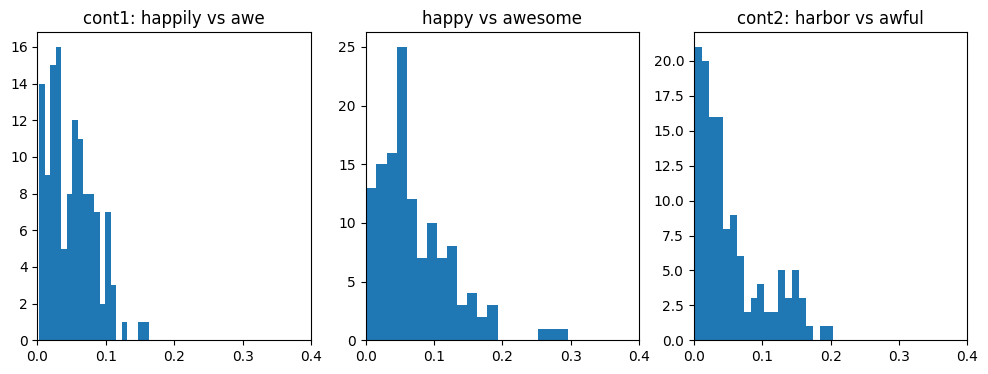

In [113]:
# plots of the differences as three different histograms
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(diffs["cont1"], bins=20)
# set x-axis limits to be the same for all three plots
plt.xlim(0,0.4)
plt.title(f"cont1: {w_at_incredible_idx_minus_1} vs {w_at_wonderful_idx_minus_1}")
plt.subplot(1,3,2)
plt.hist(diffs["word1_vs_word2"], bins=20)
plt.xlim(0,0.4)
plt.title(f"{word1} vs {word2}")
plt.subplot(1,3,3)
plt.hist(diffs["cont2"], bins=20)
plt.xlim(0,0.4)
plt.title(f"cont2: {w_at_incredible_idx_plus_1} vs {w_at_wonderful_idx_plus_1}")
plt.show()


In [114]:
# length of an input is
len(dataset[0]['x'])

3842

In [115]:
import torchtext as text
vec = text.vocab.GloVe(name='6B', dim=50)

---

#Q2: Add your two words the list of words whose embeddings are displayed and compared. Do your two chosen words have similar embeddings? In other words, is the distance between your embeddings very small?

'< I added "happy" and "awesome" to the list of words whose embeddings are compared. looking at the the heatmap, both words show close identical color patterns across all 50 embedding dimensions, this shows  that their embeddings are very similar. it also  indicates a very small distance between their vectors, sugeesting that the model understands them as semantically close.'

In [121]:
examples = ['annoy', 'annoyed', 'disappointed', 'sad', 'happy','awesome' ,'pilot', 'attendant', 'crew', 'suitcase', 'luggage', 'carryon', 'great', 'amazing', 'terrific',
'incredible', 'wonderful']
embeddings = vec.get_vecs_by_tokens(examples, lower_case_backup=True)
embeddings[0,:] # just the first embedding (you can verify by confirming that it is 50 elements long)

tensor([ 0.2346, -0.4768,  0.6346, -0.3647, -0.2198, -0.4554,  0.7078,  1.0140,
        -0.9116,  0.4700, -0.2297,  0.6649,  0.7675, -0.1076,  0.0037,  0.8933,
        -0.0952, -0.0524,  0.8839, -0.4915, -0.3554, -0.1999,  0.0198,  0.8199,
         1.0315, -0.6998, -0.2933, -0.4718,  0.8706, -1.0971, -0.6342,  1.1884,
        -0.0337, -0.3884, -0.4684,  0.0881, -0.1675, -0.4079, -0.3784, -0.1425,
         0.2098,  0.1734,  0.1954,  0.6891,  1.0228,  0.2353,  0.1960, -0.2608,
        -0.0890,  0.5791])

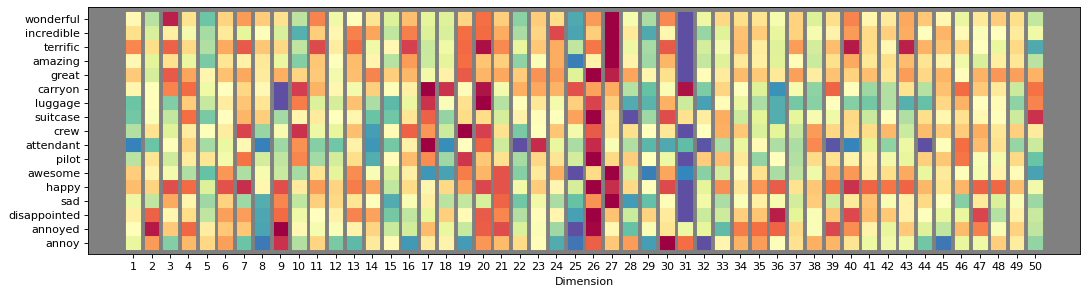

In [122]:
def compare_words_with_colors(vecs, wds):
    wdsr = wds[:]
    wdsr.reverse()

    dim = len(vecs[0])

    fig = plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.set_facecolor('gray')

    for i,v in enumerate(vecs):
        ax.scatter(range(dim), [i]*dim, c=vecs[i], cmap='Spectral', s=150, marker='s')

    plt.xticks(range(50), [i+1 for i in range(50)])
    plt.xlabel('Dimension')
    plt.yticks(range(len(wds)), wds)

    plt.show()

compare_words_with_colors(embeddings, examples)
#examples.reverse()

In [123]:
similarities = pairwise_cosine_similarity(embeddings, zero_diagonal=False)
distances = 1 - similarities
print(f"the first row of the distance matrix for our set of words looks like: {distances[0,:]}")
pairwise_top = pd.DataFrame(
    distances,
    columns = examples,
    index = examples
)

the first row of the distance matrix for our set of words looks like: tensor([1.7881e-07, 4.3455e-01, 7.1622e-01, 7.6653e-01, 7.2499e-01, 7.9840e-01,
        1.1374e+00, 8.8526e-01, 1.1141e+00, 1.0229e+00, 9.5620e-01, 9.6831e-01,
        9.7373e-01, 9.7172e-01, 9.3245e-01, 9.6144e-01, 8.6686e-01])


In the cell above we created a distance matrix, let's now see what it looks like. Note that since we are plotting pairwise distances, larger values will be red and will suggest that the word the corresponding row is far away from the word in the corresponding columns (and vice versa).

Similarly, words that are similar to each other will have a smaller distance (close to zero), and will be plotted in green.

<Axes: >

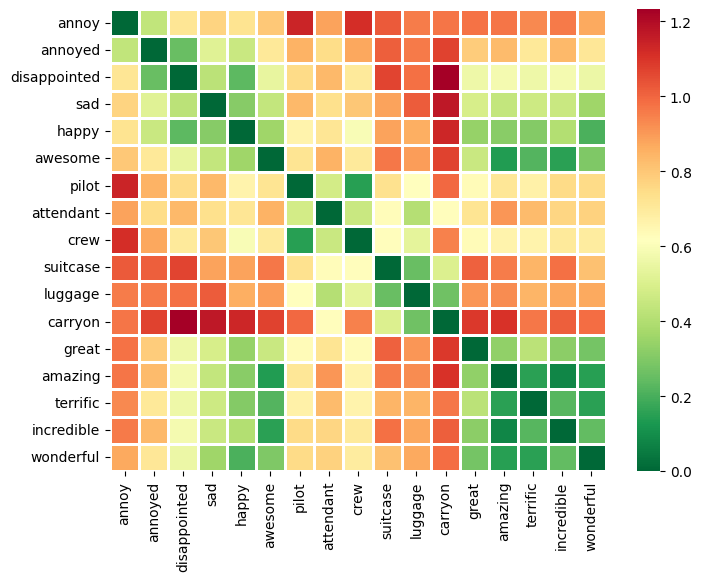

In [124]:
plt.figure(figsize=(8,6))
#sns.color_palette("viridis", as_cmap=True)
sns.color_palette("mako", as_cmap=True)
sns.heatmap(
    pairwise_top,
    cmap='RdYlGn_r',  # Reverse the 'RdYlGn' colormap to have green for larger values and red for smaller values
    linewidth=1
)


In [125]:
data_URL = 'https://raw.githubusercontent.com/sgeinitz/DSML4220/main/data/airlinetweets.csv'
df = pd.read_csv(data_URL)
print(f"df.shape: {df.shape}")
pd.set_option("display.max_colwidth", 240)
df.head(10)

df.shape: (10000, 2)


,sentiment,text
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!
4,negative,@VirginAmerica hold times at call center are a bit much
5,negative,@USAirways not moving we are in the tarmac delayed for some unknown reason. I'll keep you posted
6,neutral,"@JetBlue What about if I booked it through Orbitz? My email is correct, but there's a middle party."
7,negative,@united 2nd flight also delayed no pilots! But they boarded is so we can just sit here! #scheduling
8,negative,".@AmericanAir after 50 minutes on hold, and another 30 minutes on the call yes. Going to be pushing it to get to the airport on time now"
9,positive,@JetBlue flight 117. proud to fly Jet Blue!


In [126]:
random.seed(2)
indices = list(range(len(df)))
random.shuffle(indices)

df_test = df.iloc[indices[9000:],]
df = df.iloc[indices[:9000],]

In [58]:
df.sentiment.value_counts(normalize=False)

,count
sentiment,
negative,5882
neutral,1720
positive,1398


In [127]:
import torchtext
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english") # "basic_english"   "subword" uses revtok module (but does not work with GLoVE)
df['tokens_raw'] = df['text'].apply(lambda x: tokenizer(x.lower()))
df.head()

,sentiment,text,tokens_raw
7010,positive,@AmericanAir I ended up on a flight to LA my fourth time on standby. Thanks! http://t.co/NA5G5EAKPA,"[@americanair, i, ended, up, on, a, flight, to, la, my, fourth, time, on, standby, ., thanks, !, http, //t, ., co/na5g5eakpa]"
9477,neutral,@JetBlue thanks! I only loose 'em at airports...1st time we found it. I think @fitbit needs to make flexes that stay on when carrying bags!,"[@jetblue, thanks, !, i, only, loose, ', em, at, airports, ., ., ., 1st, time, we, found, it, ., i, think, @fitbit, needs, to, make, flexes, that, stay, on, when, carrying, bags, !]"
4584,neutral,@SouthwestAir can take u to Midway-Chicago March 8th-April 6th. Can't make it then? @AmericanAir can get u to @fly2ohare year round. #FlyPBI,"[@southwestair, can, take, u, to, midway-chicago, march, 8th-april, 6th, ., can, ', t, make, it, then, ?, @americanair, can, get, u, to, @fly2ohare, year, round, ., #flypbi]"
3460,negative,@AmericanAir is this how you let your employees treat your loyal customers? #attackingbabymomma #crazinessintherockies,"[@americanair, is, this, how, you, let, your, employees, treat, your, loyal, customers, ?, #attackingbabymomma, #crazinessintherockies]"
9065,negative,@USAirways so I still need to stay on hold? http://t.co/04SDytT7zd,"[@usairways, so, i, still, need, to, stay, on, hold, ?, http, //t, ., co/04sdytt7zd]"


In [128]:
df['tweet_length'] = df['tokens_raw'].apply(lambda x: len(x))
#plt.figure(figsize=(12,6))
#df['tweet_length'].hist() #bins=100, range=(0,45), width=0.9) #, df['tweet_length'].mean(), df['tweet_length'].median()
#plt.show()

In [129]:
df.iloc[rows_w_word1,].index.sort_values()

Index([  71,  148,  157,  176,  247,  954, 1085, 1298, 1337, 1413, 1571, 1762,
       1891, 2067, 2213, 2336, 2431, 2733, 2830, 3031, 3213, 3285, 3319, 3364,
       3470, 4088, 4314, 4384, 4500, 4669, 5028, 5322, 5642, 5687, 6025, 6026,
       6318, 6397, 6742, 6922, 7047, 7542, 7544, 7743, 7837, 7948, 7969, 8220,
       8743, 8785, 8873, 8898, 9707, 9794, 9883],
      dtype='int64')

In [130]:
tweet_i= 53
tweet_embeddings = vec.get_vecs_by_tokens(df['tokens_raw'][tweet_i], lower_case_backup=True)
print(f"sentiment of this tweet: {df['sentiment'][tweet_i]}")
print(f"tweet_embeddings.shape = {tweet_embeddings.shape}")
for i in range(df['tweet_length'][tweet_i]):
    print(f"    token, '{df['tokens_raw'][tweet_i][i]}' (at pos {i:2.0f}) has tweet_embeddings[:5] = {tweet_embeddings[i][:5]}")

sentiment of this tweet: positive
tweet_embeddings.shape = torch.Size([21, 50])
    token, '@usairways' (at pos  0) has tweet_embeddings[:5] = tensor([0., 0., 0., 0., 0.])
    token, 'great' (at pos  1) has tweet_embeddings[:5] = tensor([-0.0266,  1.3357, -1.0280, -0.3729,  0.5201])
    token, 'job' (at pos  2) has tweet_embeddings[:5] = tensor([-0.2034, -0.0452,  0.2335, -0.5929,  0.4968])
    token, 'today' (at pos  3) has tweet_embeddings[:5] = tensor([ 2.7751e-04,  4.2673e-01, -8.2938e-02,  2.7601e-01,  6.4721e-01])
    token, 'from' (at pos  4) has tweet_embeddings[:5] = tensor([ 0.4104,  0.1134,  0.0515, -0.5383, -0.1291])
    token, 'your' (at pos  5) has tweet_embeddings[:5] = tensor([-0.0292,  0.8177,  0.3847, -0.7786,  1.1049])
    token, 'team' (at pos  6) has tweet_embeddings[:5] = tensor([-0.6280,  0.1225, -0.3914,  0.8794,  0.2857])
    token, 'with' (at pos  7) has tweet_embeddings[:5] = tensor([ 0.2562,  0.4369, -0.1189,  0.2034,  0.4196])
    token, 'a' (at pos  8) has

In [131]:
df.iloc[rows_w_word2,].index.sort_values()

Index([  38,  189,  194,  244,  315,  368,  548,  579,  696,  907,  917, 1135,
       1211, 1458, 1684, 1698, 1712, 1800, 1862, 1901, 2246, 2618, 2716, 2973,
       3028, 3159, 3194, 3208, 3229, 3334, 3434, 3618, 3908, 3961, 4163, 4166,
       4246, 4266, 4419, 4540, 4893, 4898, 5377, 5419, 5420, 6198, 6217, 6313,
       6669, 6679, 6703, 6718, 6739, 7073, 7264, 7315, 7355, 7547, 7568, 7590,
       7882, 8190, 8397, 8780, 8874, 8961, 9330, 9343, 9493, 9650, 9672, 9781,
       9793, 9874],
      dtype='int64')

In [132]:
tweet_i= 18
tweet_embeddings = vec.get_vecs_by_tokens(df['tokens_raw'][tweet_i], lower_case_backup=True)
print(f"sentiment of this tweet: {df['sentiment'][tweet_i]}")
print(f"tweet_embeddings.shape = {tweet_embeddings.shape}")
for i in range(df['tweet_length'][tweet_i]):
    print(f"    token, '{df['tokens_raw'][tweet_i][i]}' (at pos {i:2.0f}) has tweet_embeddings[:5] = {tweet_embeddings[i][:5]}")

sentiment of this tweet: positive
tweet_embeddings.shape = torch.Size([26, 50])
    token, '@united' (at pos  0) has tweet_embeddings[:5] = tensor([0., 0., 0., 0., 0.])
    token, 'this' (at pos  1) has tweet_embeddings[:5] = tensor([ 0.5307,  0.4012, -0.4078,  0.1544,  0.4778])
    token, 'flight' (at pos  2) has tweet_embeddings[:5] = tensor([ 1.7306,  0.2840, -0.0406, -0.0874, -0.4819])
    token, 'has' (at pos  3) has tweet_embeddings[:5] = tensor([0.5482, 0.0388, 0.1013, 0.3132, 0.0955])
    token, 'been' (at pos  4) has tweet_embeddings[:5] = tensor([ 0.9288, -0.7246,  0.0681, -0.3816, -0.0387])
    token, 'amazing' (at pos  5) has tweet_embeddings[:5] = tensor([-0.0131,  0.4220, -0.2632,  0.3422,  0.9992])
    token, '.' (at pos  6) has tweet_embeddings[:5] = tensor([ 0.1516,  0.3018, -0.1676,  0.1768,  0.3172])
    token, 'this' (at pos  7) has tweet_embeddings[:5] = tensor([ 0.5307,  0.4012, -0.4078,  0.1544,  0.4778])
    token, 'is' (at pos  8) has tweet_embeddings[:5] = ten

The tweet above had 9 tokens in it, which we can quickly confirm here by looking at the shape of it:

In [133]:
tweet_embeddings.shape

torch.Size([26, 50])

Before we continue we must decide what a good length will be for a max-length of the number of tokens to keep. Let's look at a histogram of the lenghts of each tweet (where length equals the number of raw tokens).

In [134]:
def meanTweetEmbeddings(raw_tokens):
    embeddings = vec.get_vecs_by_tokens(raw_tokens, lower_case_backup=True)
    n_embs = 0
    emb_sum = torch.zeros((embeddings.shape[1]))
    for i in range(min(embeddings.shape[0], 35)): # max number of tokens in a tweet is 35
        if embeddings[i].abs().sum() > 0:
            n_embs += 1
            emb_sum += embeddings[i]
    if n_embs > 0:
        emb_avg = emb_sum / n_embs
    else:
        emb_avg = torch.zeros((embeddings.shape[1]))
    if np.any(np.isnan(emb_avg.numpy())):
        print(f"exists an nan: {emb_sum}")
    return emb_avg

X_int = df['tokens_raw'].apply(lambda x: meanTweetEmbeddings(x)).values
print(f"X_int.shape = {X_int.shape}")
X_int[:2]

X_int.shape = (9000,)


array([tensor([ 0.3028,  0.2039, -0.0204, -0.0364,  0.2067, -0.2280, -0.4656,  0.0248,
               -0.1765, -0.0233, -0.0744,  0.0589, -0.4326, -0.0424,  0.4923, -0.0899,
               -0.2986, -0.1104, -0.5854, -0.2348,  0.0585,  0.2551,  0.1341, -0.0644,
                0.1468, -1.4109, -0.1199,  0.1557,  0.3670, -0.2906,  3.1477,  0.2847,
               -0.4861,  0.1838, -0.0458, -0.1027,  0.3055,  0.0647,  0.2258, -0.3096,
                0.1175, -0.0254, -0.0304, -0.1005, -0.2504,  0.0678,  0.1295, -0.2639,
                0.1226,  0.0941])                                                     ,
       tensor([ 0.2300,  0.1307,  0.1504, -0.1903,  0.3168, -0.1768, -0.3275, -0.0873,
               -0.1575, -0.0853,  0.0046,  0.2163, -0.4331, -0.0597,  0.4884,  0.3020,
                0.0195, -0.0078, -0.3931, -0.4089, -0.0188,  0.1957,  0.3602,  0.0474,
                0.2363, -1.5497, -0.4142,  0.1548,  0.4343, -0.4096,  3.0166,  0.4833,
               -0.3818, -0.0280, -0.0193, 

In [135]:
X_int[0].shape

torch.Size([50])

In [136]:
if len(X_int[0] > 50):
    avg_embedding = False
else:
    avg_embedding = True

X = torch.stack(tuple(X_int))
X.shape
#X[:2]

torch.Size([9000, 50])

There should be 9000 rows in X, since this is the number of tweets (i.e. observations) in the training data.

The number of columns is the _embedding size_ itself.

In [137]:
labels = df['sentiment'].unique()
enum_labels = enumerate(labels)
label_to_idx = dict((lab, i) for i,lab in enum_labels)
print(f"label dictionary: {label_to_idx}")
y = torch.tensor([label_to_idx[lab] for lab in df['sentiment']])

label dictionary: {'positive': 0, 'neutral': 1, 'negative': 2}


In [138]:
# Can be a good idea to occassionally check that the dims (or shapes) agree for the inputs (X) and labels (y)
assert len(X) == len(y)

In [139]:
class AirlineTweetDataset(Dataset):
    def __init__(self, observations, labels):
        self.obs = observations
        self.labs = labels
        self.create_split(len(observations))

    def create_split(self, n, seed=2, train_perc=0.7):
        random.seed(seed)
        indices = list(range(n))
        random.shuffle(indices)
        self._train_ids = list(indices[:int(n * train_perc)])
        self._test_ids = list(indices[int(n * train_perc):])
        self._split_X = self.obs[self._train_ids]
        self._split_y = self.labs[self._train_ids]

    def set_split(self, split='train'):
        if split == 'train':
            self._split_X = self.obs[self._train_ids]
            self._split_y = self.labs[self._train_ids]
        else:
            self._split_X = self.obs[self._test_ids]
            self._split_y = self.labs[self._test_ids]

    def __len__(self):
        return len(self._split_y)

    def __getitem__(self, idx):
        return {'x':self._split_X[idx], 'y':self._split_y[idx]}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

dataset = AirlineTweetDataset(X, y)
dataset.create_split(len(X), seed=42, train_perc=0.85)

In [140]:
dataset.set_split('train')
print(f"len(dataset) = {len(dataset)}")
len(dataset[:]['x'])
dataset[0]['x']

len(dataset) = 7650


tensor([ 1.9947e-01,  2.2978e-01,  3.1434e-01, -7.2406e-02,  1.3215e-01,
        -2.8928e-01, -2.6313e-01,  8.9965e-02, -2.2626e-01, -1.9972e-01,
        -1.4493e-02,  1.1073e-02, -1.0883e-01,  5.4321e-02,  4.6624e-01,
         3.0225e-01, -1.1294e-01, -6.1818e-02, -5.0013e-01, -2.3225e-01,
         1.7325e-01,  9.3846e-02,  3.7863e-01,  1.1899e-01,  8.5169e-02,
        -1.1076e+00,  2.5715e-01, -6.4333e-02,  2.7661e-01, -1.6781e-01,
         2.4443e+00,  4.2160e-01, -5.8740e-01,  6.7032e-02,  4.9197e-02,
        -2.5712e-01,  3.2492e-01,  3.8803e-02,  1.3826e-01, -2.3802e-04,
         6.9949e-02,  5.5567e-02,  2.2980e-01,  6.5075e-02, -2.3257e-01,
         1.9916e-01, -4.1757e-03, -3.6493e-02, -7.3034e-02,  2.6633e-01])

In [141]:
assert not np.any(np.isnan(dataset[:]['x'].numpy()))
assert np.all(np.isfinite(dataset[:]['x'].numpy()))

#### Hyperparameters for model with GloVe embeddings

We'll use the same training configuration as before, although it is worth noting that this model would likely benefit from more training.

In [142]:
# use same batch_size, learning_rate, and epochs as before
batch_size = 32
learning_rate = 0.001
num_epochs = 20
device = 'cpu'

In [143]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# create dataset, model and define loss function and optimizer
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
model_w_embeddings = AirlineTweetClassifier(len(dataset[0]['x']), 128, 3)
loss_fun = nn.CrossEntropyLoss()#weights)
optimizer = torch.optim.Adam(model_w_embeddings.parameters(), lr=learning_rate)

In [144]:
epoch_bar = tqdm.notebook.tqdm(desc='training routine', total=num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train', total=dataset.get_num_batches(batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val', total=dataset.get_num_batches(batch_size), position=1, leave=True)

losses = {'train':[], 'val':[]}

for epoch in range(num_epochs):

    dataset.set_split('train')
    model_w_embeddings.train()
    running_loss_train = 0.0

    for batch_i, batch_data in enumerate(dataloader):
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)

        # forward
        outputs = model_w_embeddings(tweets)
        loss = loss_fun(outputs, labels)
        losses['train'].append(loss.item())
        running_loss_train += loss.item()

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if (batch_i+1) % 10 == 0:
        #    print(f"    train batch {batch_i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
            # update bar
        train_bar.set_postfix(loss=running_loss_train, epoch=epoch)
        train_bar.update()

    train_bar.set_postfix(loss=running_loss_train/dataset.get_num_batches(batch_size), epoch=epoch)
    train_bar.update()


    running_loss_train = running_loss_train / len(dataset)

    dataset.set_split('val')
    model_w_embeddings.eval() # turn off the automatic differentiation
    running_loss_val = 0.0

    for batch_i, batch_data in enumerate(dataloader):
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)


        # forward (no backward step for validation data)
        outputs = model_w_embeddings(tweets)
        loss = loss_fun(outputs, labels)
        losses['val'].append(loss.item())
        running_loss_val += loss.item()
        #if (batch_i+1) % 20 == 0:
        #    print(f"    valid batch {i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
        val_bar.set_postfix(loss=running_loss_val, epoch=epoch)
        val_bar.update()

    val_bar.set_postfix(loss=running_loss_val/dataset.get_num_batches(batch_size), epoch=epoch)
    val_bar.update()

    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

    running_loss_val = running_loss_val / len(dataset)


training routine:   0%|          | 0/20 [00:00<?, ?it/s]

split=train:   0%|          | 0/239 [00:00<?, ?it/s]

split=val:   0%|          | 0/42 [00:00<?, ?it/s]

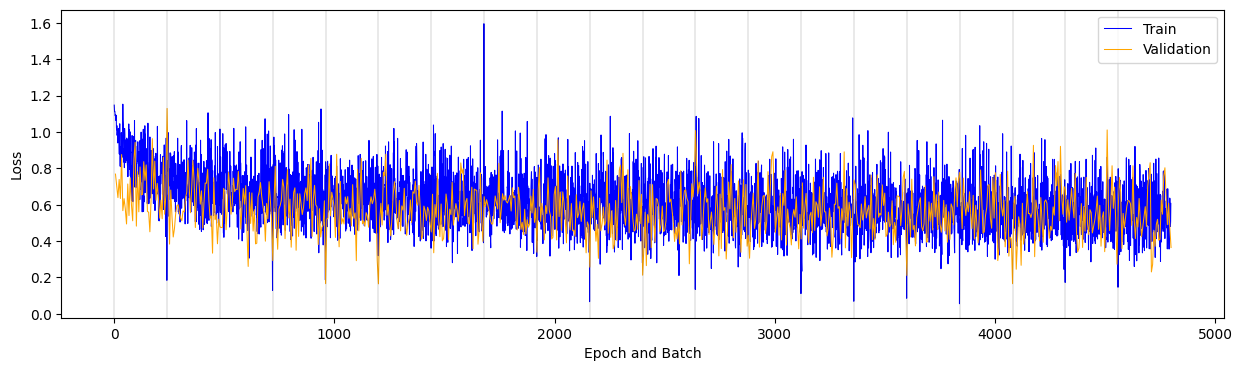

In [145]:
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(num_epochs):
    plt.axvline(x=i*len(losses['train'])/num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [146]:
# Test the model
model_w_embeddings.eval()
dataset.set_split('val')
y_true = []
y_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in dataloader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model_w_embeddings(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(dataloader)*batch_size} validation tweets): {100 * correct / total:.2f}%")


Accuracy (on 1376 validation tweets): 78.67%


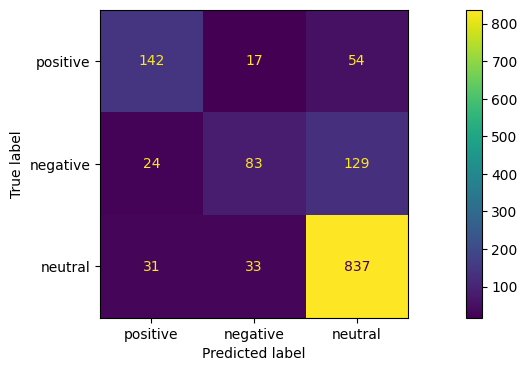

In [147]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative','neutral'])
disp.plot()

In [148]:
# length of an input is
len(dataset[0]['x'])

50

In [149]:
import torchinfo
torchinfo.summary(model_w_embeddings, tuple(dataset[0]['x'].size()))

Layer (type:depth-idx)                   Output Shape              Param #
AirlineTweetClassifier                   [3]                       --
├─Linear: 1-1                            [128]                     6,528
├─Linear: 1-2                            [32]                      4,128
├─Dropout: 1-3                           [32]                      --
├─Linear: 1-4                            [3]                       99
Total params: 10,755
Trainable params: 10,755
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.97
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04

In [150]:
50*128 + 128

6528

---

### Q3: How much smaller is the model with embeddings than the model with one-hot encoded inputs?


 The GloVe model is smaller and more efficient, while the one-hot encoded model is larger due to its learnable embedding layer. Specifically, it has about 46 times fewer parameters and is approximately 50 times smaller in memory size (MB).

